# Queens 4eg21

This implementations makes use of only the boards that host an 4ge21 FPGA.
The hardware implementation is defined for a board of 20x20 with 3 presolution columns (n=20, q=3).
For the distribution of the presolutions, Python scripts were created to automate the scaling of the demux and adder_counts blocks to match the number of solvers.
In this particular implementation 22 solvers are present in each board.

## Cluster implementation

### Configuration

In [1]:
import asyncio, time, asyncssh, re
from pathlib import Path

In [2]:
import json

with open('nodes.json') as nodes_file:
    nodes = json.load(nodes_file)['nodes']

nodes = [[d for d in nodes if d['fpga']['model'] == '4ge21'][0]]

In [3]:
import os, pwd

def ipy_profile(nodes: dict, engine_args: str, controller_ip: str) -> str :
    return f"""
# Configuration file for ipcluster.
c = get_config()  #noqa

# controller config
c.Cluster.controller_ip = '{controller_ip}'

# engine launcher config

c.Cluster.engine_launcher_class = 'ssh'

c.SSHEngineSetLauncher.engine_args = {engine_args}
c.SSHEngineSetLauncher.engines = {nodes}"""

def generate_profile(nodes: list, mpi: bool = True, engines_per_node: int= 2, controller_ip: str = '192.168.0.55', name: str = 'ssh') -> dict :
    username = pwd.getpwuid(os.getuid()).pw_name
    if mpi:
        engine_args = ["--engines=mpi", "--profile-dir=/home/mlabadm/.ipython/profile_ssh"]
    else: 
        engine_args = ["--profile-dir=/home/mlabadm/.ipython/profile_ssh"]
    profile = ipy_profile({f'mlabadm@{node["ip"]}':engines_per_node for node in nodes}, engine_args, controller_ip)
    profile_folder = f"/home/{username}/.ipython/profile_{name}"
    if os.path.isdir(profile_folder):
        print("Profile exists, rewritting configuration.")
    else:
        print("Profile does not exist, creating new profile.")
        os.mkdir(profile_folder) 
    with open(profile_folder + "/ipcluster_config.py", 'w') as file:
        file.write(profile)
    return 

generate_profile(nodes, mpi= True, engines_per_node= 1)

Profile exists, rewritting configuration.


### Creation

In [4]:
import ipyparallel as ipp

engines = 1

cluster = ipp.Cluster(profile="ssh", n=engines) # profile is short hand for profile_dir/profile_""
rc = cluster.start_and_connect_sync()

Starting 1 engines with <class 'ipyparallel.cluster.launcher.SSHEngineSetLauncher'>
ensuring remote mlabadm@192.168.0.7:.ipython/profile_ssh/security/ exists
sending /home/jupyter-mlabadm/.ipython/profile_ssh/security/ipcontroller-1689972198-rcyg-client.json to mlabadm@192.168.0.7:.ipython/profile_ssh/security/ipcontroller-1689972198-rcyg-client.json
ensuring remote mlabadm@192.168.0.7:.ipython/profile_ssh/security/ exists
sending /home/jupyter-mlabadm/.ipython/profile_ssh/security/ipcontroller-1689972198-rcyg-engine.json to mlabadm@192.168.0.7:.ipython/profile_ssh/security/ipcontroller-1689972198-rcyg-engine.json
Running `python3 -m ipyparallel.engine --engines=mpi --profile-dir=/home/mlabadm/.ipython/profile_ssh`


  0%|          | 0/1 [00:00<?, ?engine/s]

## FPGA configuration and LKM init

In [5]:
start_time = 0

def progress_handler(from_file, to_file, bytes_copied, total_size):
    time_spent = time.perf_counter() - start_time
    print(f"{from_file} -> {to_file} {bytes_copied/time_spent:06.2f}", end='\r')

async def scp_handler(host: str, filename: str):
    try:
        async with asyncssh.connect(host, username='mlabadm') as conn:
            await asyncssh.scp(filename, (conn, '/tmp/'), progress_handler = progress_handler)
            return 1
    except (OSError, asyncssh.Error) as exc:
        print(f'Error: SSH connection failed {str(exc)}')
        return 0

async def upload_firmware(destination_nodes: list, filename: str):
    # check that the destination nodes have valid ips
    # collect targetted fpgas to validate the files
    for node in destination_nodes:
        if not( 'ip' in node.keys()):
            print(f'Error: missing ip in node {node}')
            return
        if not('fpga' in node.keys()):
            print(f'Error: missing fpga in node {node}')
            return
        # check that the both filename.bin and filename.dtsi files are available is present in ~/bitstreams and both 
        bit  = Path(f"~/bitstreams/{filename}-{node['fpga']['model']}.bit.bin").expanduser()
        dtbo  = Path(f"~/bitstreams/{filename}-{node['fpga']['model']}.dtbo").expanduser()
        if not (bit.is_file() and dtbo.is_file()):
            print(f"Error: missing configuration files for FPGA {node['fpga']['model']}")
            return
        if not await scp_handler(node['ip'], bit):
            print(f"Error: failed to copy {bit} to {node['ip']}.")
            return
        if not await scp_handler(node['ip'], dtbo):
            print(f"Error: failed to copy {dtbo} to {node['ip']}.")
            return

async def fpgautil_handler(host: str, firmware: str):
    try:
        async with asyncssh.connect(host, username='mlabadm') as conn:
            result = await conn.run(f'sudo fpgautil -b /tmp/{firmware}.bit.bin -o /tmp/{firmware}.dtbo\n')
            print(result.stdout, end= '')
            return 1
    except (OSError, asyncssh.Error) as exc:
        print(f'Error: SSH connection failed {str(exc)}')
        return 0

async def program_fpgas(destination_nodes: list, filename: str):
    # check that the destination nodes have valid ips
    # collect targetted fpgas to validate the files
    for node in destination_nodes:
        if not( 'ip' in node.keys()):
            print(f'Error: missing ip in node {node}')
            return
        if not('fpga' in node.keys()):
            print(f'Error: missing fpga in node {node}')
            return
        firmware = f"{filename}-{node['fpga']['model']}"
        if not await fpgautil_handler(node['ip'], firmware):
            print(f"Error: failed to program {node['ip']}.")
            return
        else:
            node['fpga']['firmware'] = firmware

async def read_state(host: str):
    try:
        async with asyncssh.connect(host, username='mlabadm') as conn:
            result = await conn.run(f'sudo cat /sys/class/fpga_manager/fpga0/state')
            return result.stdout
    except (OSError, asyncssh.Error) as exc:
        print(f'Error: SSH connection failed {str(exc)}')
        return 0

async def read_fpgas_state(destination_nodes: list):
    # check that the destination nodes have valid ips
    # collect targetted fpgas to validate the files
    for node in destination_nodes:
        if not( 'ip' in node.keys()):
            print(f'Error: missing ip in node {node}')
            return
        if not('fpga' in node.keys()):
            print(f'Error: missing fpga in node {node}')
            return
        result = await read_state(node['ip'])
        if not result:
            break
        else:
            node['fpga']['state'] = result

async def insmod(host: str):
    try:
        async with asyncssh.connect(host, username='mlabadm') as conn:
            await conn.run(f'sudo insmod comblock.ko')
            result = await conn.run(f'ls /dev/ComBlock*')
            return result.stdout
    except (OSError, asyncssh.Error) as exc:
        print(f'Error: SSH connection failed {str(exc)}')
        return 0

async def load_driver(destination_nodes: list):
    # check that the destination nodes have valid ips
    # collect targetted fpgas to validate the files
    for node in destination_nodes:
        if not( 'ip' in node.keys()):
            print(f'Error: missing ip in node {node}')
            return
        if not('fpga' in node.keys()):
            print(f'Error: missing fpga in node {node}')
            return
        result = await insmod(node['ip'])
        if not result:
            break
        else:
            devfiles = re.findall(r'_\d+_([a-z_]+)', result)
            node['comblock']['devs'].append(devfiles)

In [6]:
await upload_firmware(nodes[:engines], 'nqueens-n6-q3')
await program_fpgas(nodes[:engines], 'nqueens-n6-q3')

Time taken to load BIN is 170.000000 Milli Secondsge21.dtbo' -> b'' 000.10.81
BIN FILE loaded through FPGA manager successfully


In [7]:
await load_driver(nodes[:engines])

## Experiment setup

## Calculate presolutions

In [8]:
dview = rc[:]

with dview.sync_imports():
    from ipyparallel.datapub import publish_data
    import os, time, re
    from struct import unpack
    import numpy as np
    from contextlib import ExitStack

importing publish_data from ipyparallel.datapub on engine(s)
importing os on engine(s)
importing time on engine(s)
importing re on engine(s)
importing unpack from struct on engine(s)
importing numpy on engine(s)
importing ExitStack from contextlib on engine(s)


In [9]:
import numpy as np

# total number of columns in the board
n = 20 
# number of columns calculated by software to be later distributed to the nodes
m = 3

def presols_list(n,m) -> list : ## run on hub then distribute (m-1)
    presols = []
    aux = [] # no idea what is the purpose of this one
    for i in range(int(np.ceil(n/2))): # symmetry simplification
        aux.append([i+1])
    presols.append(aux) # presols takes a list [1,..,n/2]
    for i in range(m-1): # columns to precalculate?
        presols.append([]) # empty list per column?
        for j in presols[i]: # j is the index of aux, first column?
            for l in np.arange(1,n+1,1): 
                counter = 0
                for h,k in enumerate(j):            
                    if ((k != l) and (np.abs(k - l) != (i+1-h))): # check if proposed solution is valid
                        counter += 1
                    else:
                        break
                if counter == (i+1): # not sure what it is counting
                    aux = j[:] # ??
                    aux.append(l) #??
                    presols[i+1].append(aux) # ??
    return presols

def int_to_binary(n,m):
    if n == 0:
        return "0"
    binary1 = ""
    while n > 0:
        binary1 = str(n % 2) + binary1
        n = n // 2
    binary2 = "0" * (m - len(binary1)) + binary1 # 
    return binary2

presols_i = presols_list(n,m)[m-1]
presols_o = []
for i in presols_i:
    presol = ""
    for j in i:
        presol += int_to_binary(j,6)
    presols_o.append(int(presol,2))

### Problem implementation

In [10]:
solutions = [0, 1 ,0 ,0 ,2 ,10 ,4 ,40 ,92 ,352 ,724 ,2680 ,14200 ,73712 ,365596 ,2279184 ,14772512 ,95815104 ,666090624 ,4968057848 ,39029188884 ,314666222712 ,2691008701644 ,24233937684440 ,227514171973736 ,2207893435808352 ,22317699616364044 ,234907967154122528]

In [11]:
def calculate_solutions_fpga(presols):
    # helper function to open files
    def open_dev_file(filename, osargs, fargs):
        return os.fdopen(os.open(filename, osargs), fargs, buffering = 0)

    # open dev files for init
    with ExitStack() as stack:
        reg_o = stack.enter_context(open_dev_file(f"/dev/ComBlock_0_regs_o", os.O_WRONLY, "bw"))
        reg_i = stack.enter_context(open_dev_file(f"/dev/ComBlock_0_regs_i", os.O_RDONLY, "br"))
        fifo_o = stack.enter_context(open_dev_file(f"/dev/ComBlock_0_fifo_o", os.O_WRONLY, "bw"))
        reg_o.seek(0)
        reg_o.write((1).to_bytes(4, 'little')) # write reg0 (reset high)
        fifo_o.seek(-1)
        last_sol = 0
        for i, presol in enumerate(presols):
            # write until fifo is full
            try:
                fifo_o.write((presol).to_bytes(4, 'little')) # write one solution per fifo
                last_sol += 1
            except:
                break
        reg_o.seek(0)                        # go back to reg0
        reg_o.write((0).to_bytes(4, 'little')) # write reg0 (reset low)

        i = 0
        reg_i.seek(0)
        done = int.from_bytes(reg_i.read(4), 'little')
        while(not done): # read reg0 (done)
            time.sleep(60)
            i += 1
            reg_i.seek(4)
            sol_l = int.from_bytes(reg_i.read(4), 'little')   # read reg1
            reg_i.seek(8)
            sol_h = int.from_bytes(reg_i.read(4), 'little')   # read reg2
            sol = (sol_h << 32) + sol_l
            reg_i.seek(0)
            done = int.from_bytes(reg_i.read(4), 'little')
            publish_data(dict(sol=sol, i=i))
            # feed remainig presolutions to keep fifo full until no more presols are available
            while fifo_o.tell() < 1024 and last_sol < len(presols):
                fifo_o.write((presols[last_sol]).to_bytes(4, 'little')) # write one solution per fifo
                last_sol += 1
        sol_l = int.from_bytes(reg_i.read(4), 'little') # read reg1
        sol_h = int.from_bytes(reg_i.read(4), 'little') # read reg2
    return (sol_h << 32) + sol_l, i

### Monitoring

In [12]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def plot_current_results(data, sols, engines, in_place= True, goal= None):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.

    Parameters
    ----------
    data : list of async result data dictionary
    
    sols: list of lists
        holds all previous points for each engine separately
    
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    try:
        for i, d in enumerate(data):
            if len(sols) < engines:
                sols.append([d['sol']])
            else:
                sols[i].append(d['sol'])
    except KeyError:
        # This can happen if we read from the engines so quickly that the data
        # hasn't arrived yet.
        fig, ax = plt.subplots()
        ax.plot([])
        ax.set_title("No data yet")
        display(fig)
        return fig, sols 
    else:
        fig, ax = plt.subplots()
        [ax.plot(sol, label=f'Engine {i}') for i,sol in enumerate(sols)]
        total = np.sum(sols, axis=0)
        ax.plot(total, label='Total', color='purple')

        if isinstance(total, np.ndarray):
            x = len(total)
        else:
            x = 1

        if goal:
            ax.hlines(y=[goal], xmin=0, xmax=x, colors='red', linestyles='--', lw=1, label='Goal')
        
        ax.set_title("Progress plot, Engines: %i" % (engines))
        ax.set_ylabel('solutions')
        ax.set_xlabel('time (m)')
        ax.legend()

        # We clear the notebook output before plotting this if in-place
        # plot updating is requested
        if in_place:
            clear_output(wait=True)
        fig.tight_layout()
        display(fig)

        return fig, sols

def monitor_task(ar, engines, refresh= 60.0, plots_in_place= True, goal= None):
    """Monitor the task progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and task status.

    Parameters
    ----------
    ar : async result object

    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 60s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time

    data = []
    sols = []
    # handle single engine or multiple engines
    if isinstance(ar.data, dict):
        data.append(ar.data) 
    else:
        data= ar.data

    if ar.ready():
        ar.get() 
        ar.wait_for_output()
        fig, sols = plot_current_results(data, sols, engines, in_place=plots_in_place, goal=goal)
        plt.close('all')
        print('Simulation has already finished, no monitoring to do.')
        return

    t0 = dt.datetime.now()
    fig = None
    try:
        while not ar.ready():
            fig, sols = plot_current_results(data, sols, engines, in_place=plots_in_place, goal=goal)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh)
    except (KeyboardInterrupt, ipp.error.TimeoutError):
        msg = 'Monitoring interrupted, task is ongoing!'
    else:
        msg = 'Task completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output(wait=True)
        plt.close('all')
        display(fig)
        plt.figure(fig)
        plt.savefig(f"progress_chart_{engines}_{tmon}.pdf", format="pdf", bbox_inches="tight")
    print(msg)
    print('Monitored for: %s.' % tmon)

### Execution

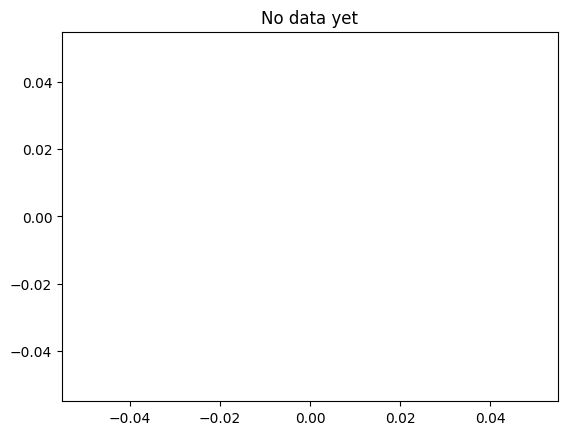

Task completed!
Monitored for: 0:01:00.189932.
wall time  :    1.2s
Serial time:    1.2s
Speedup    :    1.0x / 1
Efficiency :   98.9%


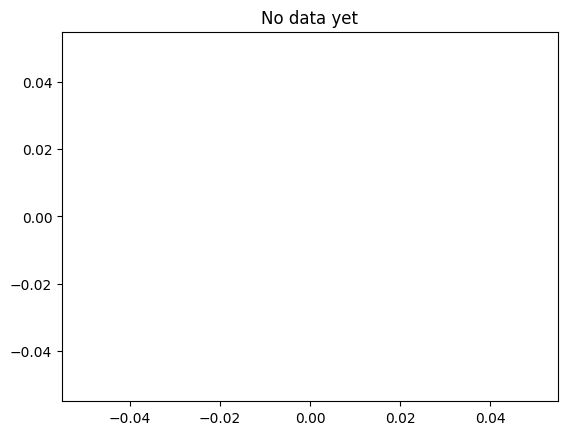

In [13]:
from random import shuffle

%matplotlib inline

dview.block = False

#chunk_size = len(presols_o)//engines + 1
#shuffle(presols_o)
#ar = dview.map_async(calculate_solutions_fpga, [presols_o[chunk_size*i:chunk_size*(i+1)] for i in range(engines)])
ar = dview.map_async(calculate_solutions_fpga, presols_o)

monitor_task(ar, engines, goal= solutions[20])

wall_time = ar.wall_time
serial_time = ar.serial_time
speedup = serial_time / wall_time
n_engines = len(set(ar.engine_id))
efficiency = speedup / n_engines

print(f"wall time  : {wall_time:6.1f}s")
print(f"Serial time: {serial_time:6.1f}s")
print(f"Speedup    : {speedup:6.1f}x / {n_engines}")
print(f"Efficiency : {efficiency:7.1%}")

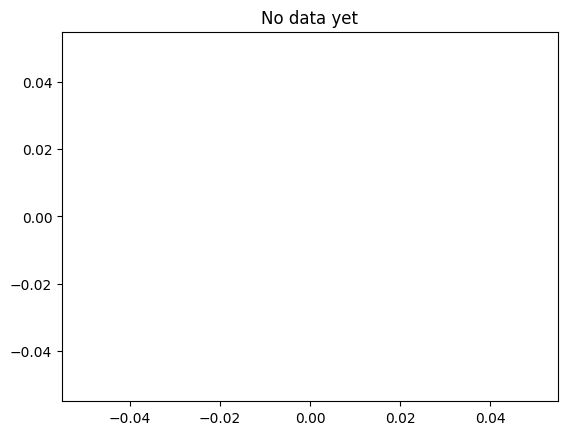

Task completed!
Monitored for: 0:01:00.166731.
wall time  :    0.3s
Serial time:    0.3s
Speedup    :    0.9x / 1
Efficiency :   90.4%


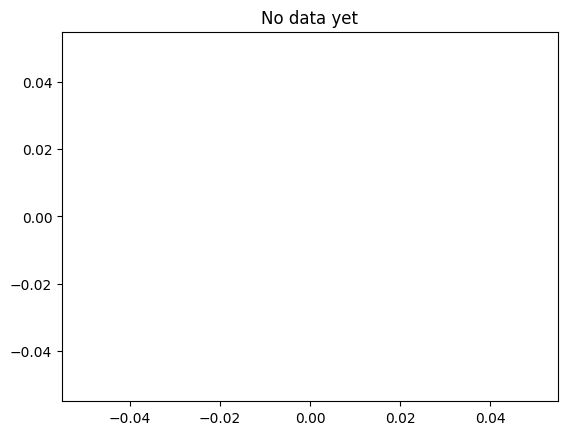

In [14]:
#shuffle(presols_o)
#ar = dview.map_async(calculate_solutions_fpga, [presols_o[chunk_size*i:chunk_size*(i+1)] for i in range(engines)])
ar = dview.map_async(calculate_solutions_fpga, presols_o)

monitor_task(ar, engines, goal= solutions[20])

wall_time = ar.wall_time
serial_time = ar.serial_time
speedup = serial_time / wall_time
n_engines = len(set(ar.engine_id))
efficiency = speedup / n_engines

print(f"wall time  : {wall_time:6.1f}s")
print(f"Serial time: {serial_time:6.1f}s")
print(f"Speedup    : {speedup:6.1f}x / {n_engines}")
print(f"Efficiency : {efficiency:7.1%}")

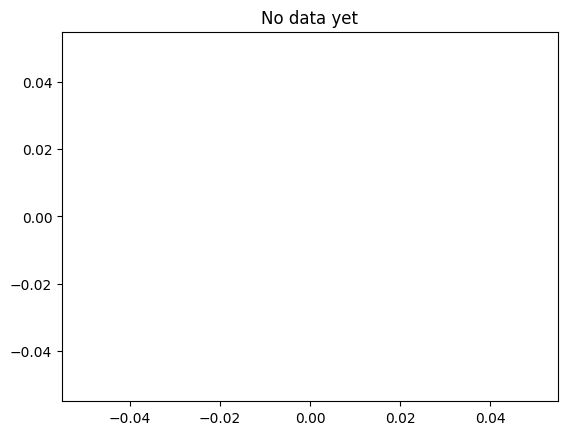

Task completed!
Monitored for: 0:01:00.175990.
wall time  :    0.3s
Serial time:    0.3s
Speedup    :    0.9x / 1
Efficiency :   88.3%


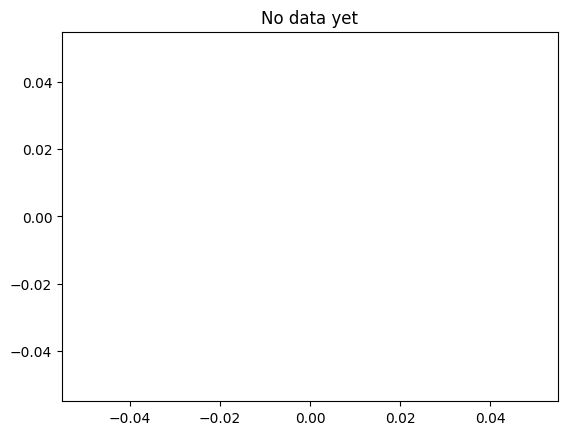

In [15]:
ar = dview.map_async(calculate_solutions_fpga, presols_o)

monitor_task(ar, engines, goal= solutions[20])

wall_time = ar.wall_time
serial_time = ar.serial_time
speedup = serial_time / wall_time
n_engines = len(set(ar.engine_id))
efficiency = speedup / n_engines

print(f"wall time  : {wall_time:6.1f}s")
print(f"Serial time: {serial_time:6.1f}s")
print(f"Speedup    : {speedup:6.1f}x / {n_engines}")
print(f"Efficiency : {efficiency:7.1%}")

# Destruction of the cluster

In [16]:
rc.shutdown()
await cluster.stop_cluster()
await cluster.stop_controller()

Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 29248, 'identifier': 'ipcontroller-1689972198-rcyg-29218'}
Stopping engine(s): 1689972199
fetching /tmp/tmpfee5oiz5/ipengine-1689972210.2386.out from mlabadm@192.168.0.7:.ipython/profile_ssh/log/ipengine-1689972210.2386.out
Removing mlabadm@192.168.0.7:.ipython/profile_ssh/log/ipengine-1689972210.2386.out
engine set stopped 1689972199: {'engines': {'mlabadm@192.168.0.7/0': {'exit_code': -1, 'pid': 1083, 'identifier': 'mlabadm@192.168.0.7/0'}}, 'exit_code': -1}
